In [1]:
root_path = "C:/Users/wrksy/OneDrive/Desktop/second semester/7120CEM/course_work_7120_code/data"

In [2]:
root_path = root_path + "/"

In [4]:
! pip install transformers
! pip install evaluate
! pip install scikit-learn
! pip install -U pip
! pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

#from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import json
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_file_path = root_path + 'train.jsonl'
val_file_path = root_path + 'validation.jsonl'

train_classification_data_svm_file_path = root_path + 'train_classification_data_svm.jsonl'
undersampled_train_classification_data_svm_file_path = root_path + 'undersampled_train_classification_data_svm.jsonl'
val_classification_data_svm_file_path = root_path + 'val_classification_data_svm.jsonl'


In [7]:
# Data preprocessing

import json

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
        filtered_sentences = [
            {
                _key: _value 
                for _key, _value in _sentence.items() 
                if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']
            } 
            for _sentence in sentences
        ]
    return filtered_sentences

# Load data

train_data = load_data(train_file_path)
val_data = load_data(val_file_path)


In [8]:
# reformat data and add proper spoiler positions using simple heuristics observed during data analysis

def reformat_spoiler_positions(data):
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):

        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]

            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:

                if _start_pos_passage == -1:
                    negative_mismatch_idx.append(_idx)

                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):

                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1,
                             None)]

                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]

                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)

            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({**_sentence, 'allTargetParagraphs': all_target_paragraphs, 'refactoredSpoilerPositions': refactored_spoiler_positions})
        
    return reformatted_data, ignore_idx


In [12]:
# reformat data with proper spoiler positions
train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

ignoring idx: 546


In [13]:
# remove data datapoints where the spoiler positions don't match the actual spoiler text

def remove_bad_matches_data(data):

    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matchs = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matchs:
                        not_found_exact_matchs[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matchs[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matchs



In [14]:
# clean data
clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)

In [16]:
# flatten nested data.
# change_multi true will relable the multi-spoiler data as either phrase or passage depending on
# the length of spoiler.

def flatten_data(data, change_multi=True):
    flattened_data = []
    for _sentence in data:

        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

In [17]:
# flattened data
flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)

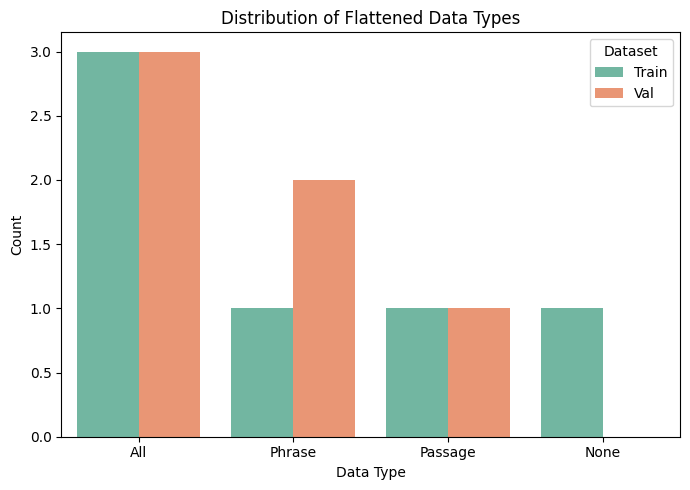

In [39]:

# flattened data distribution Barplot
flattened_train_data = [
    {'uuid': '1', 'targetParagraphId': 0, 'postText': 'post1', 'targetTitle': 'title1', 'targetParagraph': 'paragraph1', 'spoilerType': 'phrase'},
    {'uuid': '2', 'targetParagraphId': 1, 'postText': 'post2', 'targetTitle': 'title2', 'targetParagraph': 'paragraph2', 'spoilerType': 'passage'},
    {'uuid': '3', 'targetParagraphId': 2, 'postText': 'post3', 'targetTitle': 'title3', 'targetParagraph': 'paragraph3', 'spoilerType': None},
]

flattened_val_data = [
    {'uuid': '4', 'targetParagraphId': 0, 'postText': 'post4', 'targetTitle': 'title4', 'targetParagraph': 'paragraph4', 'spoilerType': 'passage'},
    {'uuid': '5', 'targetParagraphId': 1, 'postText': 'post5', 'targetTitle': 'title5', 'targetParagraph': 'paragraph5', 'spoilerType': 'phrase'},
    {'uuid': '6', 'targetParagraphId': 2, 'postText': 'post6', 'targetTitle': 'title6', 'targetParagraph': 'paragraph6', 'spoilerType': 'phrase'},
]

# flattened data distribution
distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data": ['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] is None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] is None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})

# Plotting
plt.figure(figsize=(7, 5))

# Barplot
sns.barplot(data=distribution_df, x="Data", y="Count", hue="Type", palette="Set2")

# Adjust plot labels and title
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.title('Distribution of Flattened Data Types')
plt.legend(title='Dataset')

# Show plot
plt.tight_layout()
plt.show()

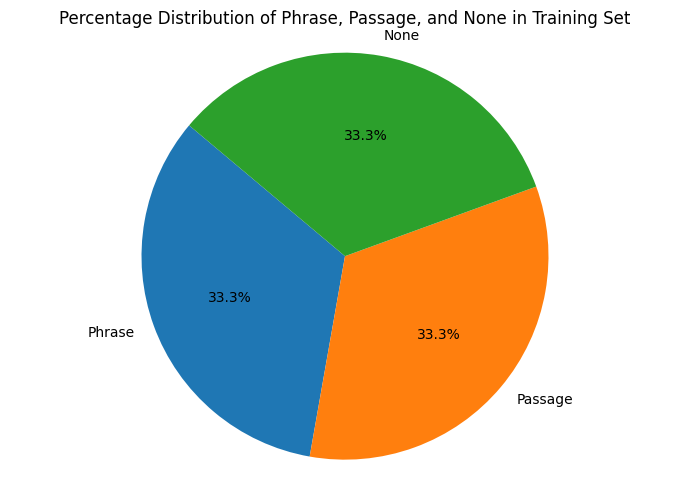

In [40]:
# flattened data distribution Pie chart
plt.figure(figsize=(7, 5))

# Filter data for pie chart
pie_data = distribution_df[distribution_df['Data'].isin(['Phrase', 'Passage', 'None'])]

# Plotting pie chart
plt.pie(pie_data[pie_data['Type'] == 'Train']['Count'], labels=pie_data[pie_data['Type'] == 'Train']['Data'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Phrase, Passage, and None in Training Set')

# Show plot
plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [41]:
# prepare classification data
def prepare_classification_data(flattened_data, undersample_ratio=1.0):
    clasification_data = []
    undersampled_data = []
    
    for _x in flattened_data:
        
        _label = 0        
        if _x['spoilerType'] == 'phrase':
            _label = 1
        elif _x['spoilerType'] == 'passage':
            _label = 2

        _data = {
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'text': _x['postText'] + ' ' + _x['targetParagraph'],
            'labels': _label,
            # **_x
          }
        clasification_data.append(_data)
    
    none_data = [_data for _data in clasification_data if _data['labels'] == 0]
    len_undersampled = int(len(none_data)*undersample_ratio)
    for _data in np.random.choice(none_data, size=len_undersampled, replace=False):
        undersampled_data.append(_data)
    for _x in clasification_data:
        if _x['labels'] in [1, 2]:
            undersampled_data.append(_x)
    
    return undersampled_data

In [42]:
# create data preapred data for further analysi and training
classification_train_data = prepare_classification_data(flattened_data=flattened_train_data)
undersampled_classification_train_data = prepare_classification_data(flattened_data=flattened_train_data, undersample_ratio=0.3)
classification_val_data = prepare_classification_data(flattened_data=flattened_val_data)


In [32]:
# reformat the data as a dataframe
df_classification_train = pd.DataFrame(columns=['text', 'labels'], data=undersampled_classification_train_data)
df_classification_val = pd.DataFrame(columns=['text', 'labels'], data=classification_val_data)



SVM Classification Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3

Logistic Regression Classification Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Naive Bayes Classification Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy  

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

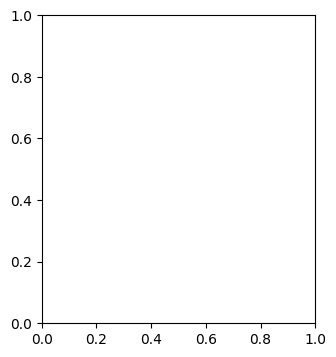

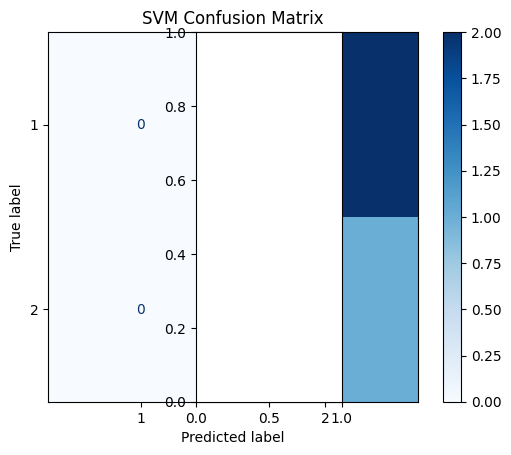

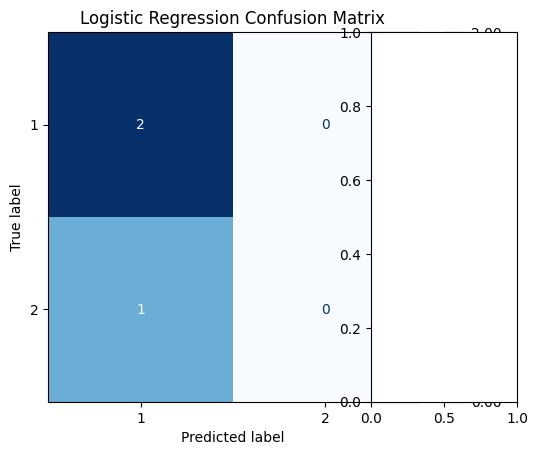

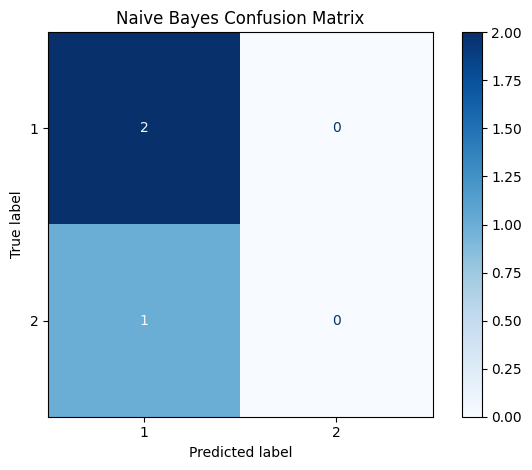

In [43]:
# ensure that the text data (x_train and x_test) is properly transformed into numerical features using a vectorizer (such as TfidfVectorizer) before training the classifiers (SVM, Logistic Regression, Naive Bayes).

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split data
x_train, x_test = df_classification_train['text'], df_classification_val['text']
y_train, y_test = df_classification_train['labels'], df_classification_val['labels']

# Encode labels
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Vectorize text data
vectorizer = TfidfVectorizer()
x_train_vector = vectorizer.fit_transform(x_train)
x_test_vector = vectorizer.transform(x_test)

# Train SVM model
clf_svm = SVC(kernel="linear", max_iter=500, C=1.0, gamma='scale')
clf_svm.fit(x_train_vector, y_train_encoded)

# Predictions for SVM
y_pred_svm = clf_svm.predict(x_test_vector)

# Train Logistic Regression model
clf_lr = LogisticRegression(max_iter=500, solver='lbfgs')
clf_lr.fit(x_train_vector, y_train_encoded)

# Predictions for Logistic Regression
y_pred_lr = clf_lr.predict(x_test_vector)

# Train Naive Bayes model
clf_nb = MultinomialNB()
clf_nb.fit(x_train_vector, y_train_encoded)

# Predictions for Naive Bayes
y_pred_nb = clf_nb.predict(x_test_vector)

# Accuracy and classification report for each classifier
print("SVM Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_svm))
print(classification_report(y_test_encoded, y_pred_svm))

print("Logistic Regression Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_lr))
print(classification_report(y_test_encoded, y_pred_lr))

print("Naive Bayes Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_nb))
print(classification_report(y_test_encoded, y_pred_nb))

# Generate confusion matrices
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
cm_lr = confusion_matrix(y_test_encoded, y_pred_lr)
cm_nb = confusion_matrix(y_test_encoded, y_pred_nb)

# Plot SVM confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=label_encoder.classes_)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')

# Plot Logistic Regression confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=label_encoder.classes_)
plt.subplot(1, 3, 2)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')

# Plot Naive Bayes confusion matrix
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=label_encoder.classes_)
plt.subplot(1, 3, 3)
disp_nb.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')

plt.tight_layout()
plt.show()
